<a href="https://www.kaggle.com/code/aurelegermain/face-mask-detection-with-yolov8?scriptVersionId=166693892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import seaborn as sns
import random

We are going to detect face masks using Yolov8. <br>
To do that we need first to load the pre-trained Yolov8 model and second to train it again using our costum dataset.

# Loading Yolov8

In [2]:
%pip install ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 6.23M/6.23M [00:00<00:00, 111MB/s]


<h4>Object detection with the pre-trained model</h4>

A few examples of object detection using Yolov8 default weights.

In [3]:
#this is function will compute the prediction, draw the boxes, and write the objects class
def make_predictions_ylov8(image):
    result = model(image, conf=0.25, verbose=False)[0]
    cmap = plt.get_cmap('hsv')

    
    boxes = result.boxes  # Boxes object for bbox outputs
    probs = result.probs  # Probs object for classification outputs
    
    image = cv2.imread(image) #opens the image with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts it to RGB

    fig, ax = plt.subplots()
    ax.set_xticks([]) #deletes x ticks 
    ax.set_yticks([]) #deletes y ticks 
    
    for xywh, classes in zip(boxes.xywh, boxes.cls):
        xmin = round(xywh[0].item() - xywh[2].item()/2)
        ymin = round(xywh[1].item() - xywh[3].item()/2)
        xmax = round(xywh[0].item() + xywh[2].item()/2)
        ymax = round(xywh[1].item() + xywh[3].item()/2)
        
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
        class_object = classes.item()
        class_name = result.names[class_object]
        
        color = plt.cm.hsv(class_object/len(result.names))[:3]
        color = [val*255 for val in color]
        
        #print(result.names[class_object])
        #cmap(classes.item()/len(result.names))))
        
        cv2.rectangle(image, start_point, end_point, color, 1) #draws the box to the image
        
        start_rect_text = (xmin, round(ymin - 20))
        end_rect_text = (round(xmin + 10*len(class_name)), ymin)

        start_text = (round(xmin + 2), round(ymin - 5))
        
        cv2.rectangle(image, start_rect_text, end_rect_text, color, -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image,class_name,start_text, font, 0.5,(0,0,0),1,cv2.LINE_AA)
    ax.imshow(image) #shows the image

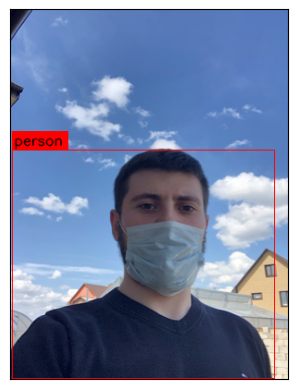

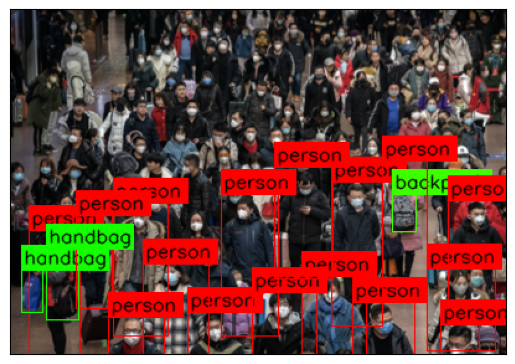

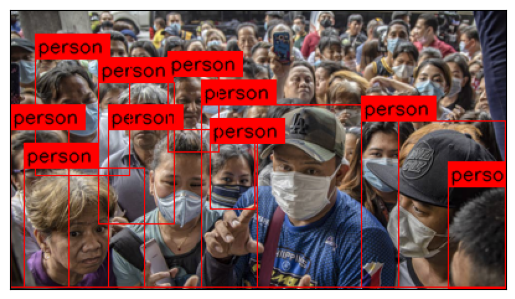

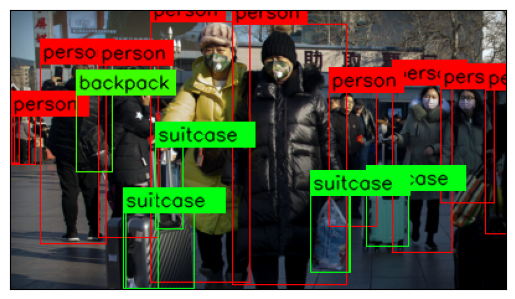

In [4]:
# Run batched inference on a list of images
list_images = ['/kaggle/input/face-mask-detection/images/maksssksksss107.png', '/kaggle/input/face-mask-detection/images/maksssksksss603.png', '/kaggle/input/face-mask-detection/images/maksssksksss52.png', '/kaggle/input/face-mask-detection/images/maksssksksss108.png']

for image in list_images:
    make_predictions_ylov8(image)

As you can see Yolo detect the people in the images (as long as there are not too many) but of course can't differentiate between masked and non masked ones as it has not yet been trained for it (these are not classes of the Yolov8 model).

# XML parser

Our dataset is made of a few hundred images. For each image we have a xml file with one rectangle (xmin, xmax, ymin, ymax) and the class (masked, unmasked, partially masked) per face contained in the image .

First we start by writting a xml parser to retrieve the annotations for each detected objects (faces) in the images.

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input/face-mask-detection/annotations'):
    for filename in filenames: #gives each file in annotations
        tree = ET.parse(os.path.join(dirname, filename))
        root = tree.getroot()
        
        #for each .xml we will make a list for the xml's tags and a list for the tag's value
        list_tag_shared = [] 
        list_text_shared = []
        
        #some tag appear more than once (more than one person per image) so we use an index to number these tags
        index = 0 
        
        for child in root:
            if len(child) > 0:
                list_tag_not_shared =[]
                list_text_not_shared =[]
                
                for i in range(len(child)):
                    
                    if len(child[i]) == 0:
                        list_tag_not_shared.append(child[i].tag)
                        list_text_not_shared.append(child[i].text)
                        
                    for j in range(len(child[i])):
                        list_tag_not_shared.append(child[i][j].tag)
                        list_text_not_shared.append(child[i][j].text)
                        
                if child.tag =='size':
                    index +=1
                    list_tag_shared += list_tag_not_shared
                    list_text_shared += list_text_not_shared
                else:
                    #we create the dataframe for each object
                    if 'df' in globals(): 
                        df = pd.concat([df,pd.DataFrame(pd.Series(data=(list_text_shared + list_text_not_shared), index=(list_tag_shared + list_tag_not_shared))).transpose()], ignore_index=True)
                    else:
                        df = pd.DataFrame(pd.Series(data=(list_text_shared + list_text_not_shared), index=(list_tag_shared + list_tag_not_shared))).transpose()
            else:
                    list_tag_shared.append(child.tag)
                    list_text_shared.append(child.text)

In [6]:
df.head()

folder             filename width height depth segmented  \
0  images  maksssksksss737.png   400    226     3         0   
1  images  maksssksksss737.png   400    226     3         0   
2  images  maksssksksss737.png   400    226     3         0   
3  images  maksssksksss737.png   400    226     3         0   
4  images  maksssksksss737.png   400    226     3         0   

                    name         pose truncated occluded difficult xmin ymin  \
0              with_mask  Unspecified         0        0         0   28   55   
1              with_mask  Unspecified         0        0         0   98   62   
2  mask_weared_incorrect  Unspecified         0        0         0  159   50   
3              with_mask  Unspecified         0        0         0  293   59   
4              with_mask  Unspecified         0        0         0  352   51   

  xmax ymax  
0   46   71  
1  111   78  
2  193   90  
3  313   80  
4  372   72

# Pre-process of the dataset

Now we search columns that have only one value and delete them from the Dataframe.

In [7]:
list_columns_len_1 = []
for column in df.columns:
    print(column, len(df[column].value_counts()))
    if len(df[column].value_counts()) == 1:
        list_columns_len_1.append(column)

folder 1
filename 853
width 39
height 104
depth 1
segmented 1
name 3
pose 1
truncated 1
occluded 1
difficult 1
xmin 406
ymin 270
xmax 411
ymax 356


In [8]:
print(list_columns_len_1)

['folder', 'depth', 'segmented', 'pose', 'truncated', 'occluded', 'difficult']


In [9]:
df = df.loc[:,~df.columns.isin(list_columns_len_1)]
df.head()

filename width height                   name xmin ymin xmax ymax
0  maksssksksss737.png   400    226              with_mask   28   55   46   71
1  maksssksksss737.png   400    226              with_mask   98   62  111   78
2  maksssksksss737.png   400    226  mask_weared_incorrect  159   50  193   90
3  maksssksksss737.png   400    226              with_mask  293   59  313   80
4  maksssksksss737.png   400    226              with_mask  352   51  372   72

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   width     4072 non-null   object
 2   height    4072 non-null   object
 3   name      4072 non-null   object
 4   xmin      4072 non-null   object
 5   ymin      4072 non-null   object
 6   xmax      4072 non-null   object
 7   ymax      4072 non-null   object
dtypes: object(8)
memory usage: 254.6+ KB


We transform the relevant columns into float32 dtype.

In [11]:
list_columns_float = ['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
df[list_columns_float] = df[list_columns_float].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4072 non-null   object 
 1   width     4072 non-null   float32
 2   height    4072 non-null   float32
 3   name      4072 non-null   object 
 4   xmin      4072 non-null   float32
 5   ymin      4072 non-null   float32
 6   xmax      4072 non-null   float32
 7   ymax      4072 non-null   float32
dtypes: float32(6), object(2)
memory usage: 159.2+ KB


Yolov8 does not use "xmin", "xmax", "ymin", "ymax", but the xy center of the rectangles and their width and heigth.

In [12]:
df['w'] = (df['xmax'] - df['xmin'])/df['width']
df['h'] = (df['ymax'] - df['ymin'])/df['height']
df['x'] = (df['xmin']/df['width']) + df['w']/2
df['y'] = (df['ymin']/df['height']) + df['h']/2

Now we look at the data, and more particularly at the *name* and *filename* columns.

In [13]:
df.name.value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: name, dtype: int64

<Axes: xlabel='name', ylabel='count'>

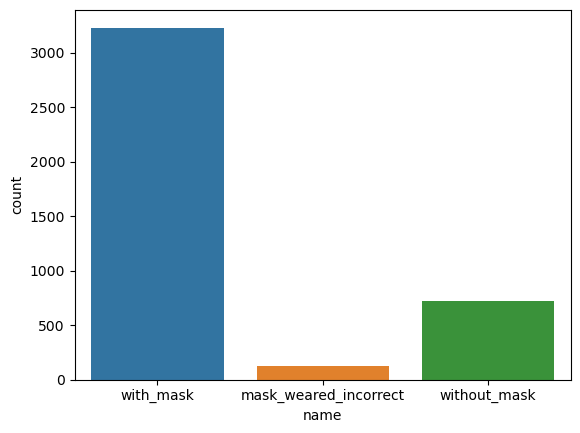

In [14]:
sns.countplot(x=df.name)

There is a disproportionate number of people with mask compared to the two other possibilities (without mask and mask worn incorrectly).

We can now count the number of object found per file and describe the results.

In [15]:
df.filename.value_counts()

maksssksksss603.png    115
maksssksksss518.png     83
maksssksksss240.png     61
maksssksksss260.png     53
maksssksksss52.png      51
                      ... 
maksssksksss727.png      1
maksssksksss404.png      1
maksssksksss819.png      1
maksssksksss266.png      1
maksssksksss212.png      1
Name: filename, Length: 853, dtype: int64

In [16]:
df.filename.value_counts().describe()

count    853.000000
mean       4.773740
std        7.394114
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      115.000000
Name: filename, dtype: float64

Some files have a dispropotionate amount of detected objects compared to the majority of the dataset, but the vast majority has less than 6 masks per images.

We map the 3 labels.

In [17]:
name_map = {'without_mask':'0', 'with_mask':'1', 'mask_weared_incorrect':'2'}
df['name'] = df['name'].map(name_map)

In [18]:
df.head()

filename  width  height name   xmin  ymin   xmax  ymax       w  \
0  maksssksksss737.png  400.0   226.0    1   28.0  55.0   46.0  71.0  0.0450   
1  maksssksksss737.png  400.0   226.0    1   98.0  62.0  111.0  78.0  0.0325   
2  maksssksksss737.png  400.0   226.0    2  159.0  50.0  193.0  90.0  0.0850   
3  maksssksksss737.png  400.0   226.0    1  293.0  59.0  313.0  80.0  0.0500   
4  maksssksksss737.png  400.0   226.0    1  352.0  51.0  372.0  72.0  0.0500   

          h        x         y  
0  0.070796  0.09250  0.278761  
1  0.070796  0.26125  0.309735  
2  0.176991  0.44000  0.309735  
3  0.092920  0.75750  0.307522  
4  0.092920  0.90500  0.272124

We can plot some images and the boxes for each object found. 
When we load the images we resize them so we also need to resize the boxes.

<h4>With PIL and Matplotlib</h4>

In [19]:
def plot_images(fig_shape, size=(200,200)):
    
    list_images = df.filename.unique()[fig_shape.flatten()] #flattens fig_shpae to obtain a list of image ids
    
    color_map = {'0':'r', '1':'g', '2':'b'} #dictionary indicating the color coding depending on the category
    
    image_folder = '/kaggle/input/face-mask-detection/images/'

    fig, ax = plt.subplots(fig_shape.shape[0],fig_shape.shape[1], figsize=(10, 10)) 
    
    image_id = 0 #starts by the first id
    
    for row in ax:
        for col in row:
            name_image = list_images[image_id] #selects the image_id in the list
            image = os.path.join(image_folder, name_image) #image path
            
            image = Image.open(image) #opens the image with PIL
            image = image.convert("RGB") #converts it to RGB
            image = image.resize(size) #resizes the image to size
            
            image_array = np.asarray(image) #converts the image to a numpy array
            
            col.imshow(image_array) #plots the image array
            
            col.set_xticks([]) #deletes x ticks 
            col.set_yticks([]) #deletes y ticks
            
            boxes_df = df[df.filename == name_image][['name','width','height', 'xmin', 'ymin', 'xmax', 'ymax']] #selects all the boxes of the image
            
            for box_id in boxes_df.index: #iterates other the indexes
                box = boxes_df.loc[box_id] #select the box
                color  = color_map[box['name']] #selects the color from the category

                ratio_x = size[0]/box['width'] #computes the ratio in the x direction to resize the box
                ratio_y = size[1]/box['height'] #computes the ratio in the y direction to resize the box
                
                #resizes each x and y value
                x_min = box['xmin']*ratio_x
                y_min = box['ymin']*ratio_y
                x_max = box['xmax']*ratio_x
                y_max = box['ymax']*ratio_y
                
                width  = x_max - x_min #computes the width of the box
                height = y_max - y_min #computes the height of the box
                
                col.add_patch(Rectangle((x_min,y_min),width, height, fc='none', color=color)) #adds the box to the image
            image_id += 1 #increments the image_id

In [20]:
figure_shape = np.random.randint(len(df.filename.unique()), size=(3, 3)) #selct random images from df and put their id in a (size) matrix

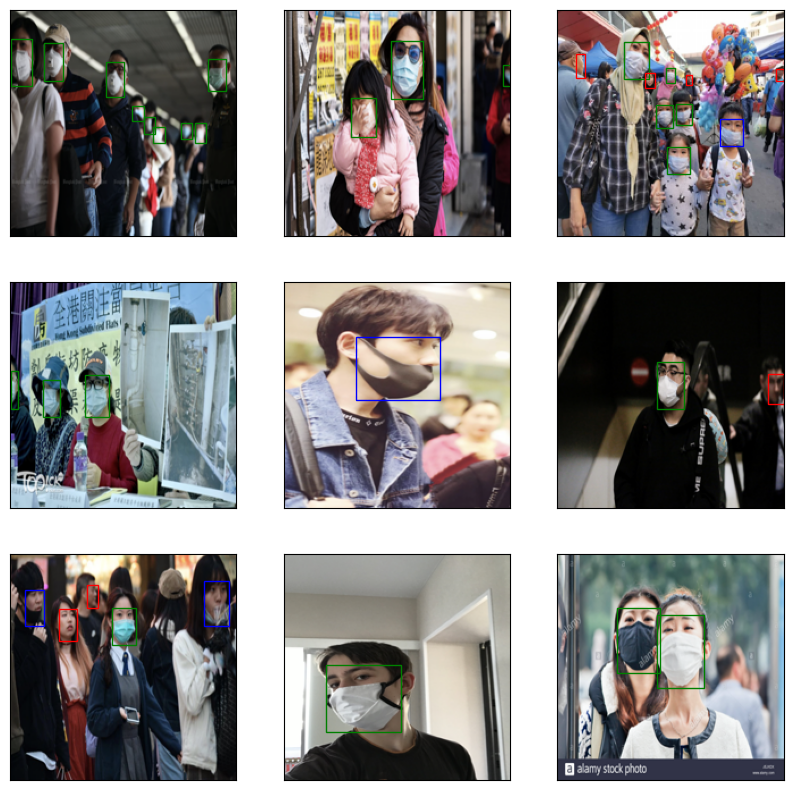

In [21]:
plot_images(figure_shape)

<h4>With OpenCV</h4>

In [22]:
def plot_images_OpenCV(fig_shape, size=(200,200)):
    
    list_images = df.filename.unique()[fig_shape.flatten()] #flattens fig_shpae to obtain a list of image ids
    
    color_map = {'0':(255,0,0), '1':(0,255,0), '2':(0,0,255)} #dictionary indicating the color coding depending on the category (rgb values as we use OpenCV)
    
    class_names = {'0': 'No mask', '1':'Mask', '2':'Incorrect'}
    
    text_padding = {'0': 45, '1': 26, '2': 44}
    
    image_folder = '/kaggle/input/face-mask-detection/images/'

    fig, ax = plt.subplots(fig_shape.shape[0],fig_shape.shape[1], figsize=(10, 10))
    
    image_id = 0 #starts by the first id
    
    for row in ax:
        for col in row:
            name_image = list_images[image_id] #selects the image_id in the list
            
            image = os.path.join(image_folder, name_image) #image path
            image = cv2.imread(image) #opens the image with OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts it to RGB
            image =  cv2.resize(image, size) #resizes the image to size

            col.set_xticks([]) #deletes x ticks 
            col.set_yticks([]) #deletes y ticks 
            
            boxes_df = df[df.filename == name_image][['name','width','height', 'xmin', 'ymin', 'xmax', 'ymax']] #selects all the boxes of the image
            
            for box_id in boxes_df.index: #iterates other the indexes
                
                box = boxes_df.loc[box_id] #select the box
                color  = color_map[box['name']] #selects the color from the category

                ratio_x = size[0]/box['width'] #computes the ratio in the x direction to resize the box
                ratio_y = size[1]/box['height'] #computes the ratio in the y direction to resize the box
                
                #resizes each x and y value
                #we use round because cv2.rectangle needs int values
                x_min = round(box['xmin']*ratio_x)
                y_min = round(box['ymin']*ratio_y)
                x_max = round(box['xmax']*ratio_x)
                y_max = round(box['ymax']*ratio_y)
                
                #cv2.rectangle needs the top left point and the bottom right point to draw the box
                start_point = (x_min, y_min) 
                end_point = (x_max, y_max)
                
                cv2.rectangle(image, start_point, end_point, color, 1) #draws the box to the image
                
                #this part adds the rectangle + class on top of the box
                class_name = class_names[box['name']]
                padding = text_padding[box['name']]
                
                start_rect_text = (x_min, round(y_min - 10))
                end_rect_text = (round(x_min + padding), y_min)

                start_text = (round(x_min + 2), round(y_min - 2))
        
                cv2.rectangle(image, start_rect_text, end_rect_text, color, -1)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image,class_name,start_text, font, 0.3,(0,0,0),1,cv2.LINE_AA)
                
            col.imshow(image) #shows the image
            image_id += 1 #increments the image_id

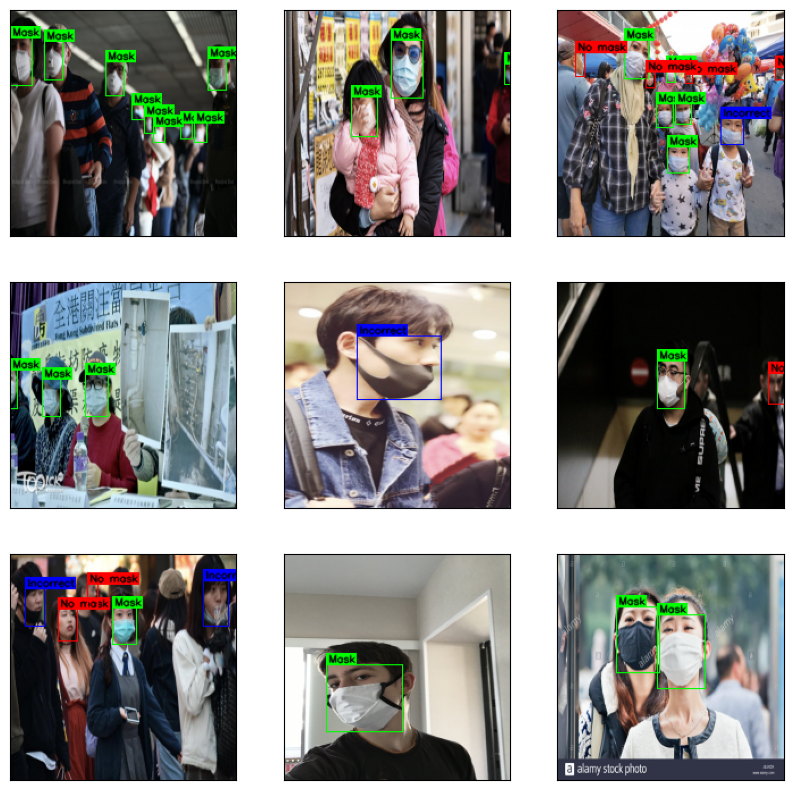

In [23]:
plot_images_OpenCV(figure_shape)

# Yolov8 custom dataset

Yolov8 expect a certain folder and file arrangement.
First the folders should be divided into "images" and "annotation". Inside each of these folders should be present a "train", "valid", and "test" folder containing the images and corresponding annotations. <br>
The annotations should be present as text files containing the classes and x, y, w, h values of each detected object (one text file per images).

We are now going to build this dataset.

In [24]:
output_folder = '/kaggle/working/annotations/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
for filename in df.filename.unique():
    with open(output_folder + filename.replace('png', 'txt'), 'a') as f:
        dfstr = df[df.filename == filename].to_string(header=False, index=False, columns=['name', 'x', 'y', 'w', 'h'])
        f.write(dfstr)

We split the images and annotations into train, val, split sets.

In [25]:
images = df.filename.unique()
annotations = [filename.replace('.png', '.txt') for filename in images]

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

Copies the images and annotations for the selected set.

In [26]:
def make_folder_mv_file(folder, images, annotations, type_set):
    
    if not os.path.exists(folder + 'images'):
        os.makedirs(folder + 'images')
        
    if not os.path.exists(folder + 'images/' + type_set):
        os.makedirs(folder + 'images/' + type_set)
    
    if not os.path.exists(folder + 'labels'):
        os.makedirs(folder + 'labels')
        
    if not os.path.exists(folder + 'labels/' + type_set):
        os.makedirs(folder + 'labels/' + type_set)

    for file, annotation in zip(images, annotations):
        shutil.copyfile('/kaggle/input/face-mask-detection/images/' + file, folder + 'images/' + type_set + '/' + file)
        shutil.move('/kaggle/working/annotations/' + annotation, folder + 'labels/' + type_set + '/' + annotation)

In [27]:
folder = '/kaggle/working/'
train_folder = '/kaggle/working/images/train'
val_folder = '/kaggle/working/images/val/'
test_folder = '/kaggle/working/images/test/'

In [28]:
make_folder_mv_file(folder, train_images, train_annotations, 'train')
make_folder_mv_file(folder, val_images, val_annotations, 'val')
make_folder_mv_file(folder, test_images, test_annotations, 'test')

Yolov8 asks for a yaml file containing the folders for each set, the number of class, and the names of the classes.


train: /kaggle/working/images/train <br>
val: /kaggle/working/images/val/ <br>
test: /kaggle/working/images/test/ <br> <br> # number of classes <br>
nc: 3 <br> <br> # class names <br>
names: ['without_mask', 'with_mask', 'mask_weared_incorrect']

In [29]:
yaml_dataset_file = open('mask_data.yaml', 'w')
file_lines = ['train: '+ train_folder, '\nval: '+ val_folder,'\ntest: '+ test_folder, '\n', '\n# number of classes', '\nnc: ' + str(len(name_map)), '\n', '\n# class names', '\nnames: ' + str(list(name_map.keys()))]
yaml_dataset_file.writelines(file_lines)
yaml_dataset_file.close()

# Yolov8 trained on custom dataset

Now we train the Yolov8 model on our costum dataset.

In [30]:
os.environ["WANDB_MODE"] = "offline" #if we don't do that inside kaggle we will be asked for an api key by wandb

# Load the model.
if os.path.isfile('/kaggle/working/runs/detect/yolov8n_custom/weights/best.pt'):
    model = YOLO('/kaggle/working/runs/detect/yolov8n_custom/weights/best.pt')
else:
    model = YOLO('/kaggle/working/yolov8n.pt')
 
    # Training.
    history = model.train(
       data='/kaggle/working/mask_data.yaml',
       imgsz=640,
       epochs=50,
       batch=8,
       name='yolov8n_custom'
    )

Ultralytics YOLOv8.1.27 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolov8n.pt, data=/kaggle/working/mask_data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Tracking run with wandb version 0.15.3
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:01<00:00, 409.16it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/val... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 386.29it/s]

val: New cache created: /kaggle/working/labels/val.cache


Plotting labels to runs/detect/yolov8n_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.33G      1.622      2.522       1.32         11        640: 100%|██████████| 86/86 [00:15<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all         85        353      0.934      0.278      0.381      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.45G      1.323      1.384      1.102         15        640: 100%|██████████| 86/86 [00:10<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         85        353      0.499      0.455      0.527      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.59G      1.265      1.179      1.072          7        640: 100%|██████████| 86/86 [00:10<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.80it/s]

                   all         85        353      0.803      0.479      0.569      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.4G      1.246      1.122      1.069         22        640: 100%|██████████| 86/86 [00:10<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.74it/s]

                   all         85        353      0.713      0.594      0.638       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.48G      1.223      1.019      1.045          9        640: 100%|██████████| 86/86 [00:10<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.97it/s]


                   all         85        353       0.68      0.623       0.66       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.55G      1.191     0.9821      1.046         12        640: 100%|██████████| 86/86 [00:11<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.94it/s]

                   all         85        353       0.87      0.578      0.673      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.45G      1.184     0.9193      1.036         19        640: 100%|██████████| 86/86 [00:10<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.30it/s]


                   all         85        353       0.85      0.598      0.714      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.44G      1.184     0.8759      1.036         29        640: 100%|██████████| 86/86 [00:10<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.57it/s]

                   all         85        353      0.636       0.74      0.748      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.35G      1.134     0.8333      1.032          7        640: 100%|██████████| 86/86 [00:10<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.01it/s]


                   all         85        353      0.755      0.674      0.731      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.35G      1.171     0.8289      1.034         12        640: 100%|██████████| 86/86 [00:10<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.86it/s]

                   all         85        353      0.824       0.62       0.72      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.57G      1.141     0.7704      1.012         18        640: 100%|██████████| 86/86 [00:11<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.61it/s]

                   all         85        353       0.83      0.718      0.807      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.59G      1.141     0.7739      1.022         20        640: 100%|██████████| 86/86 [00:10<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.08it/s]


                   all         85        353       0.72      0.678      0.737      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.46G      1.117     0.7449       1.01         30        640: 100%|██████████| 86/86 [00:10<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.61it/s]

                   all         85        353      0.726      0.731      0.784      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.45G      1.122     0.7507       1.01         19        640: 100%|██████████| 86/86 [00:10<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.65it/s]

                   all         85        353      0.837      0.703      0.817       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.53G      1.108     0.7371       1.01          3        640: 100%|██████████| 86/86 [00:10<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.94it/s]

                   all         85        353      0.816      0.721      0.791      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.49G      1.111     0.7102      1.005         35        640: 100%|██████████| 86/86 [00:11<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.75it/s]

                   all         85        353        0.8       0.71      0.762      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.3G      1.085     0.7019      1.008          9        640: 100%|██████████| 86/86 [00:10<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.41it/s]

                   all         85        353       0.87      0.729      0.833       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.38G      1.075      0.671     0.9864         21        640: 100%|██████████| 86/86 [00:10<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.97it/s]

                   all         85        353      0.849      0.724      0.797      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.44G      1.079     0.6801     0.9945          9        640: 100%|██████████| 86/86 [00:10<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.50it/s]

                   all         85        353      0.812      0.789      0.829      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.59G      1.071     0.6674     0.9855          6        640: 100%|██████████| 86/86 [00:10<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.50it/s]

                   all         85        353      0.855       0.76      0.842      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.35G      1.078     0.6565     0.9888         29        640: 100%|██████████| 86/86 [00:10<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.85it/s]


                   all         85        353      0.877      0.719      0.819      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.43G      1.059       0.64     0.9925         15        640: 100%|██████████| 86/86 [00:10<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.68it/s]

                   all         85        353      0.832       0.78      0.816      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.44G      1.028     0.6189     0.9773          7        640: 100%|██████████| 86/86 [00:10<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.46it/s]

                   all         85        353       0.81       0.73      0.807      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.43G      1.074     0.6315     0.9906         19        640: 100%|██████████| 86/86 [00:10<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.06it/s]

                   all         85        353      0.799      0.767      0.806      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.75G      1.043     0.6215     0.9721          9        640: 100%|██████████| 86/86 [00:10<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.88it/s]

                   all         85        353      0.897      0.702      0.838      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.43G      1.053     0.6206     0.9887          8        640: 100%|██████████| 86/86 [00:10<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.33it/s]

                   all         85        353      0.935      0.738      0.834      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.38G       1.03     0.5984     0.9732         11        640: 100%|██████████| 86/86 [00:10<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.77it/s]

                   all         85        353      0.835      0.794      0.846      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.44G       1.02     0.5931     0.9648          6        640: 100%|██████████| 86/86 [00:10<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.01it/s]

                   all         85        353      0.934      0.768      0.852      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.45G      1.032     0.5974     0.9736          7        640: 100%|██████████| 86/86 [00:10<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.91it/s]

                   all         85        353      0.906      0.778      0.851      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.36G      1.006      0.593     0.9697         12        640: 100%|██████████| 86/86 [00:10<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.84it/s]

                   all         85        353      0.878      0.752      0.846      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.44G      1.006     0.5769     0.9649         59        640: 100%|██████████| 86/86 [00:10<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.96it/s]

                   all         85        353      0.871      0.744      0.858      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.74G      1.001     0.5763     0.9684          4        640: 100%|██████████| 86/86 [00:10<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.18it/s]

                   all         85        353      0.957      0.732      0.857      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.35G      1.001     0.5706     0.9537         17        640: 100%|██████████| 86/86 [00:10<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.58it/s]

                   all         85        353      0.957      0.729      0.848      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.43G     0.9907     0.5611     0.9591         31        640: 100%|██████████| 86/86 [00:10<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.50it/s]


                   all         85        353      0.947      0.751      0.858      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.49G     0.9941      0.557     0.9562         17        640: 100%|██████████| 86/86 [00:10<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.04it/s]

                   all         85        353      0.857      0.726      0.835      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.46G     0.9864     0.5537     0.9576         16        640: 100%|██████████| 86/86 [00:10<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.40it/s]

                   all         85        353      0.959      0.724      0.854      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.52G     0.9506     0.5358     0.9475         39        640: 100%|██████████| 86/86 [00:10<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]

                   all         85        353      0.838      0.739      0.833      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.49G     0.9672     0.5382     0.9462         26        640: 100%|██████████| 86/86 [00:10<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.51it/s]

                   all         85        353      0.958      0.737      0.872      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.44G     0.9558     0.5235     0.9465          7        640: 100%|██████████| 86/86 [00:11<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]

                   all         85        353      0.918      0.759       0.88      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.44G     0.9411     0.5238     0.9446         16        640: 100%|██████████| 86/86 [00:10<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.81it/s]


                   all         85        353      0.957      0.744      0.871      0.585
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.35G     0.9452     0.4984     0.9426          3        640: 100%|██████████| 86/86 [00:11<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.14it/s]

                   all         85        353      0.932      0.735      0.856      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.44G     0.9559     0.4967     0.9338         16        640: 100%|██████████| 86/86 [00:10<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.50it/s]

                   all         85        353      0.842      0.788      0.857      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.45G     0.9193     0.4817     0.9246          3        640: 100%|██████████| 86/86 [00:10<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.39it/s]

                   all         85        353       0.92      0.731       0.87      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.44G     0.9173     0.4716     0.9311          4        640: 100%|██████████| 86/86 [00:10<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.44it/s]

                   all         85        353       0.96       0.73      0.887      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.44G     0.9303     0.4742     0.9375          4        640: 100%|██████████| 86/86 [00:09<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]

                   all         85        353      0.958       0.75      0.894      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.47G      0.907     0.4742     0.9278          2        640: 100%|██████████| 86/86 [00:10<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.28it/s]

                   all         85        353      0.946      0.723      0.889      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.44G     0.9022     0.4537     0.9259          6        640: 100%|██████████| 86/86 [00:10<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.94it/s]

                   all         85        353        0.9      0.751      0.878      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.48G     0.8999      0.459     0.9209          5        640: 100%|██████████| 86/86 [00:09<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]

                   all         85        353      0.916      0.764      0.886      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.44G     0.8805     0.4511     0.9196          4        640: 100%|██████████| 86/86 [00:10<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.62it/s]


                   all         85        353      0.944      0.752      0.878      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.44G     0.8827     0.4491     0.9113          8        640: 100%|██████████| 86/86 [00:10<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.09it/s]

                   all         85        353       0.96       0.72      0.876      0.596



50 epochs completed in 0.176 hours.
Optimizer stripped from runs/detect/yolov8n_custom/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_custom/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_custom/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all         85        353      0.958      0.748      0.895      0.607
          without_mask         85         68      0.915      0.789       0.91       0.61
             with_mask         85        268      0.959      0.878      0.954      0.687
 mask_weared_incorrect         85         17          1      0.577      0.821      0.524
Speed: 0.8ms preprocess, 5.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/yolov8n_custom


wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃▆████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃▆████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▃▄▅▅▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██████
wandb:     metrics/mAP50-95(B) ▁▃▃▄▅▅▆▆▇▅▆▇▆▇▇▇▇▇▇▇▇▇██▇█▇▇█▇▇█▇███████
wandb:    metrics/precision(B) █▁▆▄▇▆▃▅▆▄▄▆▆▇▆▆▇▆▆▆█▆█▇▇████▆█▇█▆▇██▇▇█
wandb:       metrics/recall(B) ▁▃▄▅▅▅▇▆▇▆▇▇▇▇▇█▇█▇█▇███▇▇▇▇▇▇▇█▇█▇▇▇▇█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
wandb:          train/cls_loss █▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:            val/box_loss █▆▄▅▄▅▅▄▄▄▃▄▄▃▃▃▃▂▃▂▃▂▁▂▂▂▃▂▁▂▂▂▂▁▂▁▁▁▁▁
wandb:            val/cls_

We look at the results using the test folder and a selection of random images.

In [31]:
def make_predictions(image, model=model):
    result = model(image, conf=0.5, verbose=False)[0]

    color_map = {0:(255,0,0), 1:(0,255,0), 2:(0,0,255)} #dictionary indicating the color coding depending on the category (rgb values as we use OpenCV)
    
    class_names = {0: 'No mask', 1:'Mask', 2:'Incorrect'}
    
    text_padding = {0: 58, 1: 34, 2: 57}
    
    boxes = result.boxes  # Boxes object for bbox outputs
    probs = result.probs  # Probs object for classification outputs
    
    image = cv2.imread(image) #opens the image with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts it to RGB

    fig, ax = plt.subplots()
    ax.set_xticks([]) #deletes x ticks 
    ax.set_yticks([]) #deletes y ticks 
    
    if len(boxes.xywh) > 5:
        annotation = False
    else:
        annotation = True
    
    for xywh, classes in zip(boxes.xywh, boxes.cls):
        xmin = round(xywh[0].item() - xywh[2].item()/2)
        ymin = round(xywh[1].item() - xywh[3].item()/2)
        xmax = round(xywh[0].item() + xywh[2].item()/2)
        ymax = round(xywh[1].item() + xywh[3].item()/2)
        
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
        class_object = classes.item()
        
        color = color_map[class_object]
        
        cv2.rectangle(image, start_point, end_point, color, 1) #draws the box to the image
        if annotation:
            
            class_name = class_names[class_object]
            padding = text_padding[class_object]
            
            start_rect_text = (xmin, round(ymin - 10))
            end_rect_text = (round(xmin + padding), ymin)

            start_text = (round(xmin + 2), round(ymin - 2))
        
            cv2.rectangle(image, start_rect_text, end_rect_text, color, -1)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image,class_name,start_text, font, 0.4,(0,0,0),1,cv2.LINE_AA)

    ax.imshow(image) #shows the image

In [32]:
test_images_shuffled = np.array([test_folder + image for image in test_images])
random_ids = np.random.randint(len(test_images_shuffled), size=10)

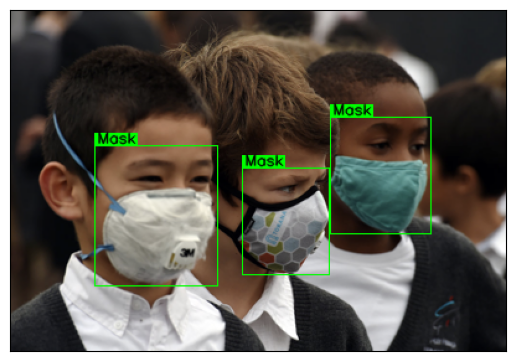

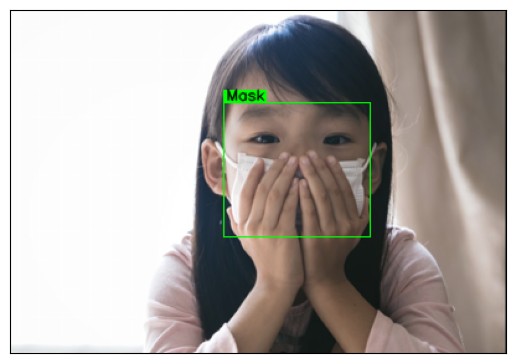

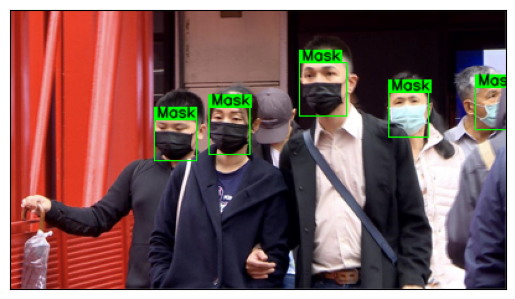

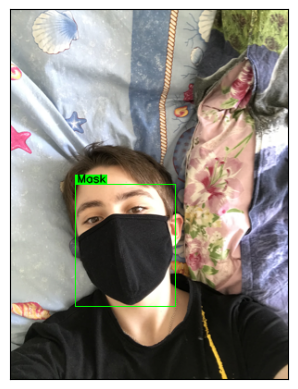

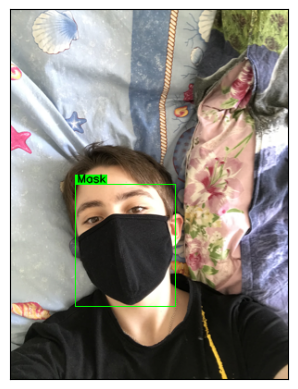

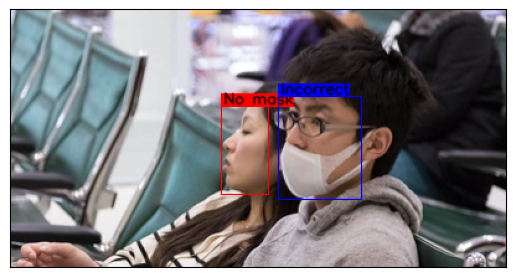

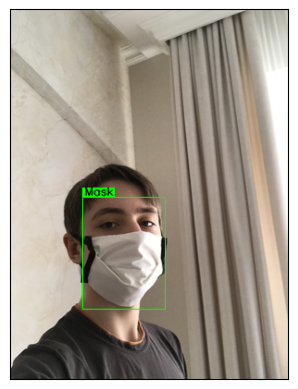

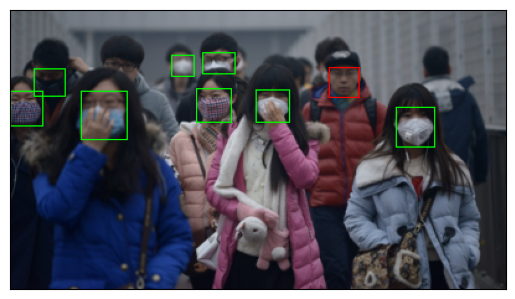

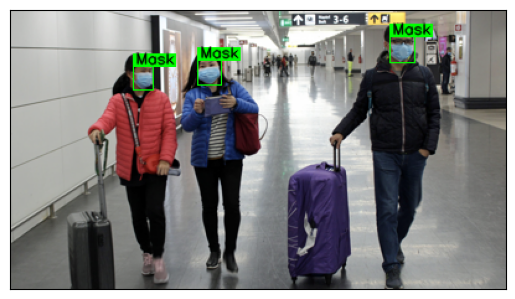

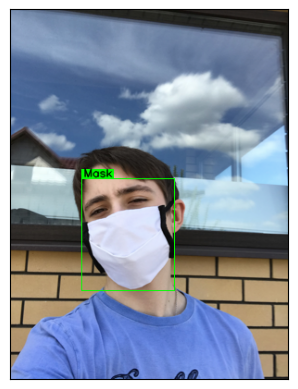

In [33]:
for image in test_images_shuffled[random_ids]:
    make_predictions(image)

So this is a quick rundown on how to use Yolo and create a custom dataset. I'm pretty pleased with the results and will of course try to learn more about Yolo and how to use it for object detection.

# Saving and loading

Yolo automaticaly save the best and last weights in the folder "/runs/detect/yolov8n_custom/weights/".

In [34]:
new_model = YOLO('/kaggle/working/runs/detect/yolov8n_custom/weights/best.pt')

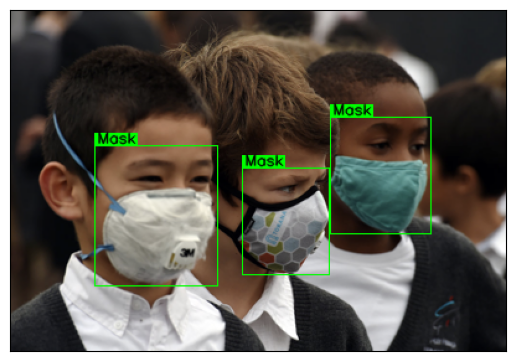

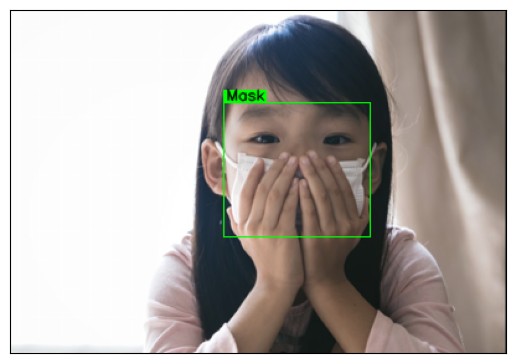

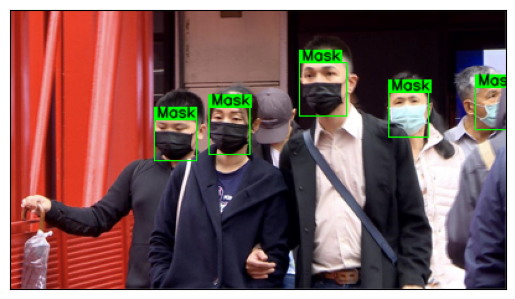

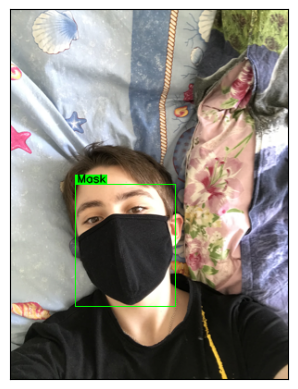

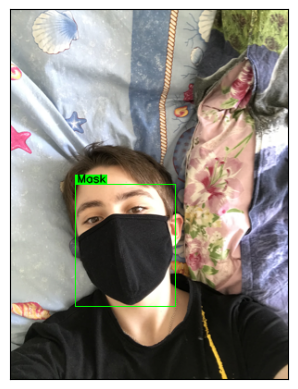

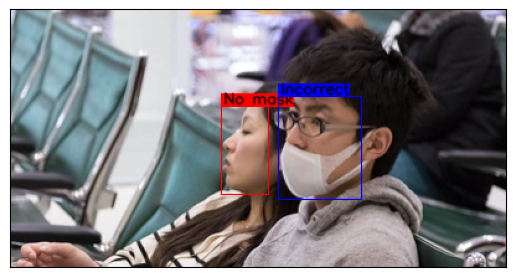

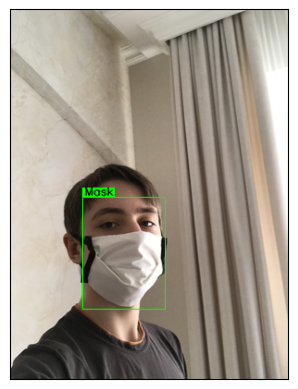

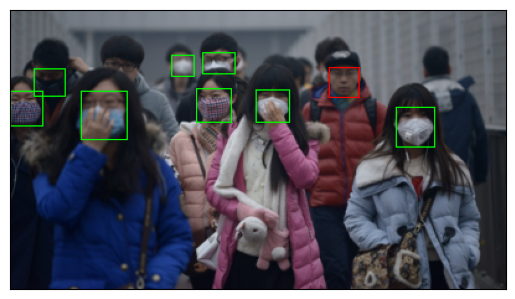

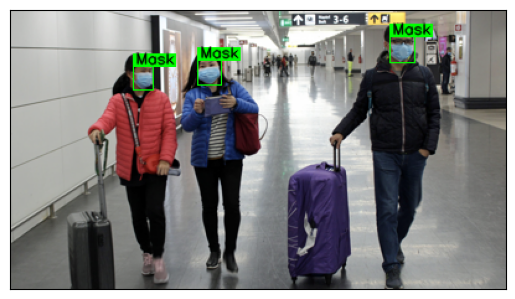

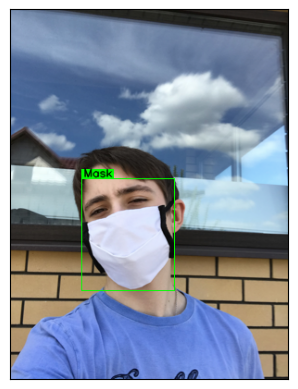

In [35]:
for image in test_images_shuffled[random_ids]:
    make_predictions(image, model=new_model)